<center><h1>OPT202 - Numerical Project n.1 : An Articulated Chain</h1></center>


<img src="Logo_ENSTA.png" width="200px">

<center><h2><i>Emma de Charry et Lucien Perdrix</i></h2></center>

Based on the template of Mr.Andrea Simonetto, dated: 31/01/2023

<strong> Setting up </strong>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#import cvxpy as cp

def cost(x):
    N = int(len(x)/2)
    e = np.zeros(2*N)
    e[N:2*N] = np.ones(N)
    return np.dot(e, x)

def residual(x, L, a, b):
    N = int(len(x) / 2)
    # r for me is c(z), r for residual
    r = np.zeros(N+1)
    r[0] = (x[0] - 0.) ** 2 + (x[N] - 0.) ** 2 - L ** 2
    for i in range(1,N):
        r[i] = (x[i] - x[i-1])**2 + (x[N+i]-x[N+i - 1])**2 - L**2
    r[N] = (a - x[N-1]) ** 2 + (b-x[2*N-1]) ** 2 - L ** 2
    return r

Some more routines to plot the chain for later.. 

In [5]:
def plot_chain(x, a, b, legend = []):
    N = int(len(x) / 2)
    xc = np.zeros(N+2)
    yc = np.zeros(N+2)
    xc[1:N+1] = x[0:N]
    xc[N+1] = a
    yc[1:N + 1] = x[N:2*N]
    yc[N + 1] = b

    plt.plot(xc,yc, 'ko-',label="Newton with convex relaxation initialization") #This line has been added to untitled our figures
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('Newtonwithcvxrelaxation2.jpg')  #This line has been added to save the figure 
    plt.show()

<strong>Gradient</strong>

In [6]:
def nabla_res(x, L, a, b):

    N = int(len(x) / 2)
    C = np.zeros([2*N, N+1])
    for i in range(1,N):
        C[i,i] = 2*(x[i]-x[i-1])
        C[i+N,i] = 2*(x[i+N]-x[i-1+N])
        if i<N-1:
            C[i,i+1] = -2*(x[i+1]-x[i])
            C[i+N,i+1] = -2*(x[i+1+N]-x[i+N])

    C[0,0] = 2*(x[0]-0.)
    C[N,0] = 2*(x[N]-0.)
    C[0, 1] = 2 * (x[0] - x[1])
    C[N, 1] = 2 * (x[N] - x[N+1])
    C[N-1,N] = -2*(a-x[N-1])
    C[2*N-1,N] = -2*(b-x[2*N-1])

    return np.mat(C)

def check_der(x, L, a, b):

    dx = 0.01*np.random.random(2*N)
    C = nabla_res(x, L, a, b)
    der = (residual(x+dx, L, a, b) - residual(x, L, a, b)) - np.dot(nabla_res(x, L, a, b).transpose(), dx)
    print('NORM ERROR: ', np.linalg.norm(der)/np.linalg.norm(dx))

    return

# Try and check:
N = 5
a,b = 1,-0.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
L = 0.25
check_der(x,L,a,b)

NORM ERROR:  0.00628573526695775


<h3> Newton's Method Elements</h3>

In [7]:
def nabla_F(x, lbd):
    """
    nabla_F computes the upper left block of the Newton's method Hessian
    """
    N = int(len(x) / 2)
    nF = np.zeros([2*N, 2*N])
    for i in range(N):
        if i>0:
            nF[i,i-1] = -2*lbd[i]
            nF[N + i, N + i - 1] = -2 * lbd[i]

        nF[i, i] = 2 * (lbd[i]+lbd[i+1])
        nF[N + i, N + i] = 2 * (lbd[i] + lbd[i + 1])


        if i<N-1:
            nF[i, i+1] = -2 * lbd[i+1]
            nF[N+i, N+i + 1] = -2 * lbd[i + 1]

    return nF

def check_nF(x, lbd, L, a, b):
    N = int(len(x) / 2)
    dx = np.random.random(2*N)

    df1 = np.dot(nabla_res(x+dx, L, a, b), lbd) - np.dot(nabla_res(x, L, a, b), lbd)
    df2 = np.dot(nabla_F(x, lbd),dx)

    print('NORM ERROR : ', np.linalg.norm(df1 - df2)/np.linalg.norm(dx))

    return

# marking sure Nabla F is correct
lmbda = 0.1*np.random.random(N+1)
check_nF(x, lmbda, L, a, b)

NORM ERROR :  1.3351321963199452e-17


In [8]:
def newton_iteration_elements(x, lbd, L, a, b):
    N = int(len(x) / 2)
    # build system
    
    A11 = nabla_F(x, lbd)
    A12 = nabla_res(x, L, a, b)
    A21 = A12.transpose()
    A22 = np.zeros([N+1, N+1])
    A1r = np.concatenate((A11, A12),axis=1)
    A2r = np.concatenate((A21, A22),axis=1)
    A = np.concatenate((A1r, A2r), axis=0)
    #
    e = np.zeros(2 * N)
    e[N:2 * N] = np.ones(N)
    rhs1 = e + np.dot(A12, lbd)
    rhs2 = residual(x, L, a, b)
    rhs = np.zeros([3*N+1])
    rhs[:2*N] = rhs1
    rhs[2*N:] = rhs2
    
    return A, rhs

<strong> Newton's iteration and solution </strong>

In [9]:
def newton_iteration(x, lbd, L, a, b, backtracking = True):
    N = int(len(x) / 2)
    # build system
    A, rhs = newton_iteration_elements(x, lbd, L, a, b)

    # solve system
    d=-np.linalg.solve(A,rhs)
    if(backtracking==True) : 
        d = np.linalg.solve(-A,rhs)
        t = 1
        beta = 1/2
        alpha = 1/4
        while np.linalg.norm(newton_iteration_elements(x+t*d[:2*N],lbd+t*d[2*N:],L,a,b)[1]) > (1-alpha*t)*np.linalg.norm(newton_iteration_elements(x,lbd,L,a,b)[1]) :
            t = beta*t
        x += t*d[:2*N]
        lbd += t*d[2*N:]
        gap = np.linalg.norm(newton_iteration_elements(x,lbd,L,a,b)[1])
    elif(backtracking==False): 
        d = -np.linalg.solve(A,rhs)
        x += d[:2*N]
        lbd += d[2*N:]
        gap = np.linalg.norm(newton_iteration_elements(x,lbd,L,a,b)[1])
    return x, lbd, gap

def solve_chain(x0, lbd0, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True):

    """
    this solves the chain with your Newton method. This controls the number of iterations and 
    the stopping criterion
    """
    err,n = 1,0
    x = x0
    lbd = lbd0
    g = list()
    while (n<Nmax) and (err>tol):
        n+=1
        
        x, lbd, gap = newton_iteration(x, lbd, L, a, b, backtracking = backtracking)
        
        g.append(gap)
        err = gap

    return x, lbd, g

def check_stationarity(x, lbd, gap):

    if gap[-1]<1e-3:
        F = nabla_F(x, lbd)
        e, dummy = np.linalg.eigh(F)
        print('Eigenvalues : ', np.min(e), np.max(e))
        if np.min(e)>0:
            print('A local optimizer found')
    return

def plot_convergence(opt_gap): 
    
    plt.loglog(opt_gap, 'o-',label="Newton with backtr")
    plt.grid()
    plt.xlabel('Iteration count')
    plt.ylabel('Optimality gap (norm residual)')
    plt.legend()
    plt.show()

<strong> Examples </strong>

Eigenvalues :  2.4794047569225617 27.105799048611605
A local optimizer found


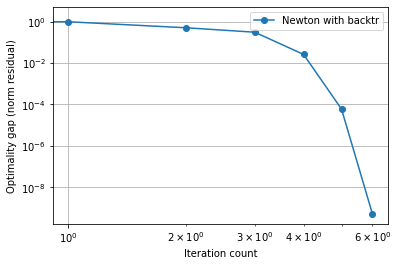

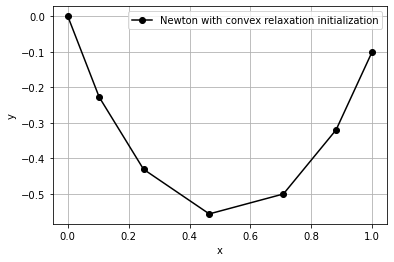

In [10]:
N = 5
L = 0.25
a,b = 1.,-.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)
plot_chain(x_sol, a, b)

### Comparaison de la convergence avec et sans backtracking

In [11]:
def plot_convergence2(opt_gap,name): 
    
    plt.loglog(opt_gap, 'o-',label=name)
    plt.grid()
    plt.xlabel('Iteration count')
    plt.ylabel('Optimality gap (norm residual)')

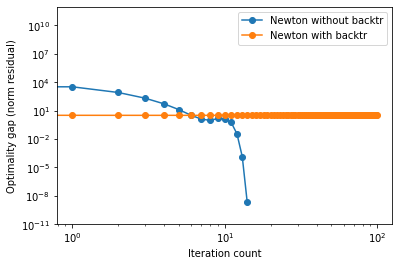

In [12]:
N = 10
L = 0.11
a,b = 1.,-.4
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap2 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
plot_convergence2(opt_gap2,"Newton without backtr")


N = 10
L = 0.11
a,b = 1.,-.4
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap1 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
plot_convergence2(opt_gap1,"Newton with backtr")

plt.ylim(0.00000000001,1000000000000)
plt.legend()
plt.savefig("Comparisonbacktrack2.jpg")
plt.show()

## Convex relaxation

### Q7

In [13]:
%pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [14]:
import cvxpy as cp

In [15]:
N=10
L = 0.11
a,b = 1.,-.4
u=cp.Variable((N+2,2))
X=cp.Variable((N+2,N+2),symmetric=True)
M = cp.bmat([[np.eye(2),u.T], [u,X]])
constraints=[]
constraints += [M >> 0]
objectiv=cp.Minimize(cp.sum(u[:,1]))
for i in range(N+1):
    constraints+=[X[i,i]-2*X[i,i+1]+X[i+1,i+1]-L**2==0]

constraints+=[u[0,:]==(0,0)]
constraints+=[u[N+1,:]==(a,b)]
constraints+=[X[0,0]==0]
constraints+=[X[N+1,N+1]==a**2+b**2]

prob=cp.Problem(objectiv,constraints)
prob.solve()


-4.006706105845463

In [16]:
np.linalg.matrix_rank(X.value)

12

Eigenvalues :  4.811793465326193 252.50370180216726
A local optimizer found
Eigenvalues :  4.811793465326193 252.50370180216726
A local optimizer found


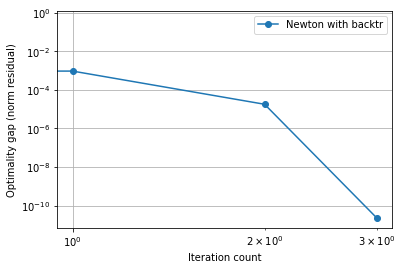

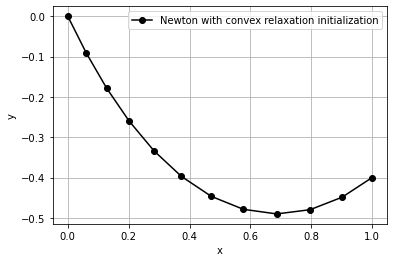

In [17]:
N = 10
L = 0.11
a,b = 1.,-.4
x=np.zeros(2*N)
x[0:N]=u.value[1:N+1,0]
x[N:2*N]=u.value[1:N+1,1]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
check_stationarity(x,lmbda_sol,opt_gap)
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)
plot_chain(x_sol, a, b)

### Affichage des 3 courbes de gap optimality sur le même graphique

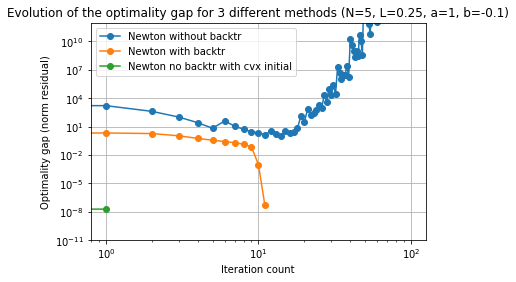

In [19]:
N = 5
L = 0.25
a,b = 1.,-.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap2 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
plot_convergence2(opt_gap2,"Newton without backtr")


N = 5
L = 0.25
a,b = 1.,-.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap1 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
plot_convergence2(opt_gap1,"Newton with backtr")

N=5
L = 0.25
a,b = 1.,-.1
u=cp.Variable((N+2,2))
X=cp.Variable((N+2,N+2),symmetric=True)
M = cp.bmat([[np.eye(2),u.T], [u,X]])
constraints=[]
constraints += [M >> 0]
objectiv=cp.Minimize(cp.sum(u[:,1]))
for i in range(N+1):
    constraints+=[X[i,i]-2*X[i,i+1]+X[i+1,i+1]-L**2==0]

constraints+=[u[0,:]==(0,0)]
constraints+=[u[N+1,:]==(a,b)]
constraints+=[X[0,0]==0]
constraints+=[X[N+1,N+1]==a**2+b**2]

prob=cp.Problem(objectiv,constraints)
prob.solve()
x=np.zeros(2*N)
x[0:N]=u.value[1:N+1,0]
x[N:2*N]=u.value[1:N+1,1]
lmbda = 0.1*np.random.random(N+1)
x_sol, lmbda_sol, opt_gap3 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
plot_convergence2(opt_gap3,"Newton no backtr with cvx initial")

plt.title("Evolution of the optimality gap for 3 different methods (N=5, L=0.25, a=1, b=-0.1)")
plt.ylim(0.00000000001,1000000000000)
plt.savefig("optgap.jpg")
plt.legend()
plt.show()